In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import sys
%pylab inline

ImportError: Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/pywrap_tensorflow.py", line 58, in <module>
    from tensorflow.python.pywrap_tensorflow_internal import *
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 28, in <module>
    _pywrap_tensorflow_internal = swig_import_helper()
  File "/usr/local/lib/python2.7/dist-packages/tensorflow/python/pywrap_tensorflow_internal.py", line 24, in swig_import_helper
    _mod = imp.load_module('_pywrap_tensorflow_internal', fp, pathname, description)
ImportError: libcublas.so.8.0: cannot open shared object file: No such file or directory


Failed to load the native TensorFlow runtime.

See https://www.tensorflow.org/install/install_sources#common_installation_problems

for some common reasons and solutions.  Include the entire stack trace
above this error message when asking for help.

In [23]:
import pywt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [11]:
def mnist_reshape_128(x, i_offset = 0, j_offset = 0):
    assert x.shape == (28 * 28,)
    image = x.reshape(28, 28)
    image = np.append(np.zeros((128 + 2, 28)), image, axis = 0)
    image = np.append(image, np.zeros((128 + 2, 28)), axis = 0)
    image = np.append(np.zeros((288, 128 + 2)), image, axis = 1)
    image = np.append(image, np.zeros((288, 128 + 2)), axis = 1)
    return image[128 + 16 - 64 + i_offset : 128 + 16 + 64 + i_offset, 128 + 16 - 64 + j_offset : 128 + 16 + 64 + j_offset]

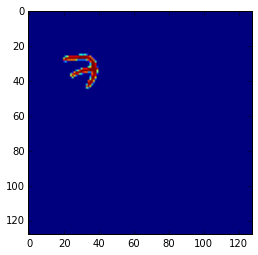

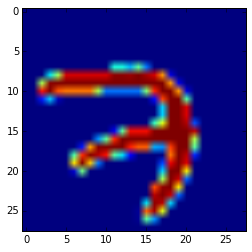

In [20]:
imshow(mnist_reshape_128(mnist.train.images[0], i_offset = 32, j_offset = 32), cmap = 'gray_r', interpolation = 'nearest')
figure()
imshow(mnist.train.images[0].reshape((28,28)), cmap = 'gray_r', interpolation = 'nearest')

In [27]:
def calc_dim(shape, h, h_max):
	assert 0 <= h < h_max
	if h == 0:
		dim_i = int(math.ceil(shape[0] * 1. / 2**(h_max - 1)))
		dim_j = int(math.ceil(shape[1] * 1. / 2**(h_max - 1)))
	else :
		dim_i = int(math.ceil(shape[0] * 1. / 2**(h_max - h)))
		dim_j = int(math.ceil(shape[1] * 1. / 2**(h_max - h)))
	return dim_i, dim_j

In [21]:
class WaveImage:
	
	def __init__(self, image = None, shape = (32, 32)):
		
		# Attribut shape
		if image is not None:
			# Decomposition ondelettes
			coeffs = pywt.wavedec2(image, 'haar')
			self.__shape = image.shape
		else:
			self.__shape = shape		
		
		# Attribut h_max : profondeur de l'image
		self.__h_max = min(int(math.log(self.__shape[0], 2)) + 1, 	int(math.log(self.__shape[1], 2)) + 1)
			
		# Attribut data : L'attribut data contient les vecteurs en position [h][u] (dictionnaire)
		if image is not None:
			self.__data = {}
			for h in range(self.__h_max):
				self.__data[h] = {}
				if h == 0:
					(i_max, j_max) = coeffs[h].shape
				else:
					(i_max, j_max) = coeffs[h][0].shape
				for i in range(i_max):
					for j in range(j_max):
						if h == 0:
							data = coeffs[h][i][j]
						else:
							data = coeffs[h][0][i][j]
							for k in range(1,len(coeffs[h])):
								data = np.append(data, coeffs[h][k][i][j])	
						self.__data[h][(i, j)] = data				
		else: # image is None
			self.__data = {}
			for h in range(self.__h_max):
				self.__data[h] = {}
					
		
	def get_data(self):
		return self.__data
	
	def get_shape(self):
		return self.__data
				
	def set_data(self, h, u, v):
		assert 0 <= h < self.__h_max
		dim_i, dim_j = calc_dim(self.__shape, h, self.__h_max)
		assert 0 <= u[0] < dim_i
		assert 0 <= u[1] < dim_j
		if h == 0 :
			self.__data[h][u] = v
		else:
			self.__data[h][u] = np.copy(v)
		
	def get_h_max(self):
		return self.__h_max
		
	def get_image(self):
		coeffs = []
		for h in range(self.__h_max):
			dim_i, dim_j = calc_dim(self.__shape, h, self.__h_max)
			if h == 0:
				coeffs_h = np.zeros((dim_i, dim_j))
				for u in self.__data[h]:
					coeffs_h[u[0],u[1]] = self.__data[h][u]
			else:
				coeffs_h = [np.zeros((dim_i, dim_j)), np.zeros((dim_i, dim_j)), np.zeros((dim_i, dim_j))]
				for u in self.__data[h]:
					for k in range(3):
						coeffs_h[k][u[0],u[1]] = self.__data[h][u][k]
			coeffs += [coeffs_h]
		return pywt.waverec2(coeffs, 'haar')	
		
	def add_coeffs(self, waveImage, u, h_ref = 0):
		# Niveau 0
		h_opp = self.__h_max - 1
		i = int(u[0] / 2**h_opp) 
		j = int(u[1] / 2**h_opp)
		u_0 = (i,j)
		if self.__data[0] == {}:
			self.__data[0][u_0] = waveImage.get_data()[0][u_0]
		else:
			v_test = self.__data[0][u_0]
			if np.linalg.norm(v_test) < 1e-16:
				self.__data[0][u_0] = waveImage.getData()[0][u_0]
		# Niveaux 1 et +
		for h in range(1, h_ref) :
			h_opp = self.__h_max - h
			i = int(u[0] / 2**h_opp) 
			j = int(u[1] / 2**h_opp)
			if (i,j) in self.__data[h]:
				v_test = self.__data[h][(i,j)]
				if np.linalg.norm(v_test) < 1e-16:
					self.__data[h][(i,j)] = np.copy(waveImage.get_data()[h][(i,j)])
			else: 
				self.__data[h][(i,j)] = np.copy(waveImage.get_data()[h][(i,j)])
	
	def copy(self):
		self_shape = self.__shape 
		self_copy = WaveImage(shape = self_shape)
		for h in range(self.__h_max) :
			for u in self.__data[h]:
				self_copy.set_data(h, u, self.__data[h][u])
		return self_copy	
		
	def __str__(self):
		h_max = len(self.__data)
		s = 'h_max :' + str(self.__h_max) + '\n'
		for h in range(self.__h_max):
			s += '***' + str(h) + '***\n'
			s += str(self.__data[h]) + '\n'
		return s


In [68]:

w1 = WaveImage(shape = (128, 128))
w2 = WaveImage(image = mnist_reshape_128(mnist.train.images[1], i_offset = -1, j_offset = -1))
w1.add_coeffs(w2, u = (63, 63), h_ref = w2.get_h_max())
w1.add_coeffs(w2, u = (63, 65), h_ref = w2.get_h_max())
w1.add_coeffs(w2, u = (65, 63), h_ref = w2.get_h_max())
w1.add_coeffs(w2, u = (65, 65), h_ref = w2.get_h_max())

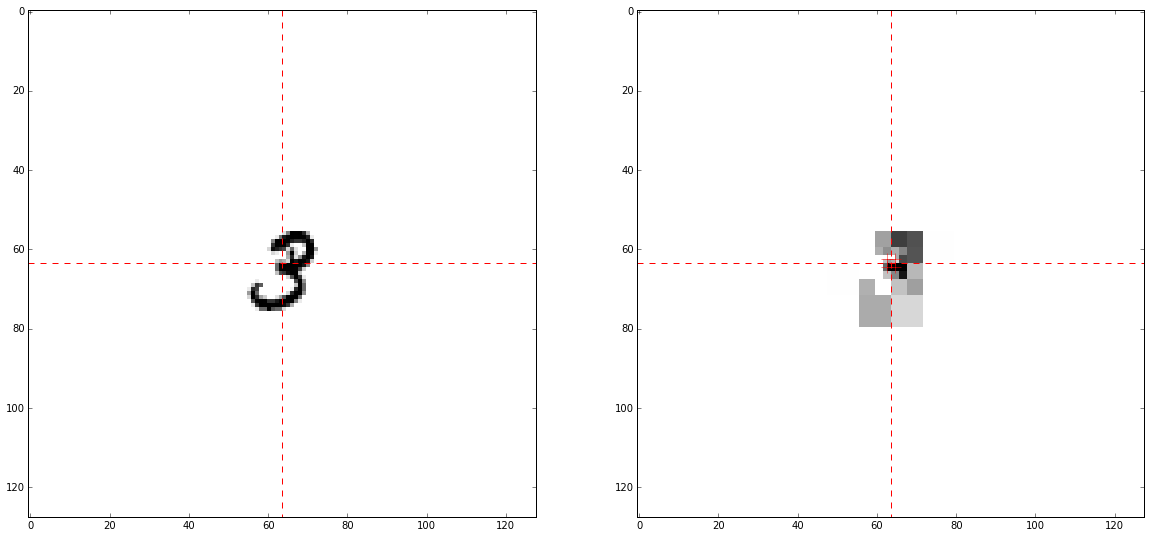

In [69]:
plt.figure(figsize = (20,20))
plt.subplot(1,2,1)
plt.imshow(w2.get_image(), cmap = 'gray_r', interpolation = 'nearest')
plt.plot([-0.5, 127.5],[63.5, 63.5],'r--')
plt.plot([63.5, 63.5],[-0.5, 127.5],'r--')
plt.xlim([-0.5, 127.5])
plt.ylim([-0.5, 127.5])
plt.gca().invert_yaxis()
plt.subplot(1,2,2)
plt.imshow(w1.get_image(), cmap = 'gray_r', interpolation = 'nearest')
plt.plot([-0.5, 127.5],[63.5, 63.5],'r--')
plt.plot([63.5, 63.5],[-0.5, 127.5],'r--')
plt.plot(63 - .5, 63 - .5, 'r+', markersize = 12)
plt.plot(63 - .5, 65 - .5, 'r+', markersize = 12)
plt.plot(65 - .5, 63 - .5, 'r+', markersize = 12)
plt.plot(65 - .5, 65 - .5, 'r+', markersize = 12)
plt.xlim([-0.5, 127.5])
plt.ylim([-0.5, 127.5])
plt.gca().invert_yaxis()

Lecture des coefficients

8

In [83]:
def generate_tensor_data(x, coord_i, coord_j):
    # coord des blocs de 4 pixels sur image 128 x 128
    # coord in [0:65[  : 32 correspond au centre exact 
    # (offset:-64:2:64)
    i_offset = -2 * (coord_i - 32)
    j_offset = -2 * (coord_j - 32)
    w1 = WaveImage(shape = (128, 128))
    w2 = WaveImage(image = mnist_reshape_128(x, i_offset = i_offset, j_offset = j_offset))
    w1.add_coeffs(w2, u = (63, 63), h_ref = w2.get_h_max())
    w1.add_coeffs(w2, u = (63, 65), h_ref = w2.get_h_max())
    w1.add_coeffs(w2, u = (65, 63), h_ref = w2.get_h_max())
    w1.add_coeffs(w2, u = (65, 65), h_ref = w2.get_h_max())
    h_max = w1.get_h_max()
    data = w1.get_data()
    tensor_data = {}
    for k in data :
        if k == 0:
            tensor_data[0] = data[k][(0, 0)]
        elif k == 1:
            tensor_data[1] = np.array(data[k][(0, 0)])    
        else:
            tensor_data[k] = np.zeros((2, 2, 3))
            for u in data[k]:           
                u_offset = 64 / (2**(h_max - k)) - 1
                tensor_data[k][u[0] - u_offset, u[1] - u_offset, :] = np.array(data[k][u])
    return w1, tensor_data

In [113]:
def generate_proximal_data(coord_i, coord_j):
    # coord des blocs de 4 pixels sur image 128 x 128
    # coord in [0:65[ : 32 correspond au centre exact 
    # (offset:-64:2:64)
    
    assert 0 <= coord_i < 65
    assert 0 <= coord_j < 65
    
    
    coord_i_set = 2 * coord_i - 64
    coord_j_set = 2 * coord_j - 64
    
    if coord_i_set < 0:
        log_offset_i = 6 - int(ceil(log2(-coord_i_set)))
    elif coord_i_set == 0:
        log_offset_i = 6 
    else:
        log_offset_i = 6 + int(ceil(log2(coord_i_set)))
        
    if coord_j_set < 0:
        log_offset_j = 6 - int(ceil(log2(-coord_j_set)))
    elif coord_j_set == 0:
        log_offset_j = 6 
    else:
        log_offset_j = 6 + int(ceil(log2(coord_j_set)))    
    
    output_matrix = np.zeros((13, 13))
    output_matrix[log_offset_i, log_offset_j] = 1
    return output_matrix

In [119]:
def generate_distal_data(coord_i, coord_j, z):
    # coord des blocs de 4 pixels sur image 32 x 32
    # coord in [0:17[ : 8 correspond au centre exact 
    # (offset:-32:2:32)
    assert 0 <= coord_i < 17
    assert 0 <= coord_j < 17    
    output_matrix = np.zeros((17, 17, 10))
    output_matrix[coord_i, coord_j, z] = 1
    return output_matrix

{0: 0.9458027552755095, 1: array([-0.94580276, -0.94580276,  0.94580276]), 2: array([[[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ],
        [-0.22591913, -0.36844365,  0.56280641]]]), 3: array([[[ 0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ]],

       [[ 0.        ,  0.        ,  0.        ],
        [-0.93002457, -0.93002457,  0.93002457]]]), 4: array([[[ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.]]]), 5: array([[[ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.]]]), 6: array([[[ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.]]]), 7: array([[[ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.]]])}


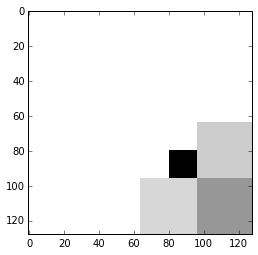

In [104]:
w, tensor_data = generate_tensor_data(mnist.train.images[0], 48, 48)
plt.imshow(w.get_image(), cmap = 'gray_r', interpolation = 'nearest')
print tensor_data

In [118]:
output_data = generate_proximal_data(-6, 60)
imshow(output_data, interpolation = 'nearest', cmap = 'gray_r')

AssertionError: 

In [102]:
ceil(log2(63))

6.0